In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

PARQUET_PATH = '/usr/datalake/silver/igra/liftedindex_lr/gph20s10k_li.parquet'
ARTIFACTS_PATH = '/usr/datalake/silver/igra/liftedindex_lr/artifacts'

epochs = 64
batch_size = 1_024
learning_rate = 0.01
learning_rate_gamma = 0.90

In [2]:
def load_dataset():
    df = pd.read_parquet(PARQUET_PATH)

    # Separate the datasets
    X = df.drop(['id', 'effective_date', 'hour', 'li'], axis=1)
    Y = df[['li']].values
        
    # Scale the X dataset
    ss = MinMaxScaler()
    X = ss.fit_transform(X)
    with open(f'{ARTIFACTS_PATH}/li_std_scaler.skl', 'wb') as f:
        pickle.dump(ss, f)
   
    return train_test_split(X, Y, test_size=0.2)

In [3]:
x_train, x_test, y_train, y_test = load_dataset()

n_batches = x_train.size // batch_size
print("Batchs: ", n_batches)
print("Training: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Batchs:  35623
Training:  (287232, 127) (287232, 1)
Test:  (71808, 127) (71808, 1)


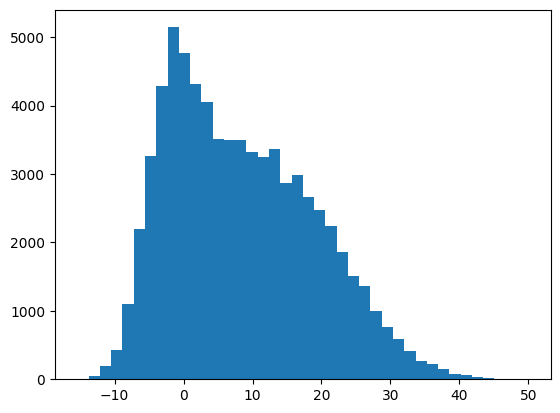

In [4]:
plt.hist(y_test, bins=40)
plt.show()

In [5]:
class LiModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(127, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 50),
            torch.nn.ReLU(),
            torch.nn.Linear(50, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)

        return logits

In [6]:
def train(model, loss_fn, optimizer, inputs, targets):
    optimizer.zero_grad()

    # Calculate error
    logits = model(inputs)
    cost = loss_fn(logits, targets)

    # Back propagation
    cost.backward()
    optimizer.step()

    return float(cost.item())

def predict(model, inputs):
    logits = model(inputs).detach()
    
    return logits

def r2_score_manual(preds, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)  # Total sum of squares
    ss_res = torch.sum((target - preds) ** 2)      # Residual sum of squares
    r2 = 1 - (ss_res / ss_tot)
    return float(r2.item())

def make_graph(y_test, y_pred):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    ax1.title.set_text('Interesting Region')
    ax1.scatter(y_test, y_pred)
    ax1.plot((-14, 50), (-14, 50), c='k')
    ax1.set_xlabel('actual')
    ax1.set_ylabel('prediction')
    ax1.set_ylim(-14, 6)
    ax1.set_xlim(-14, 6)

    ax2.title.set_text('Full Region')
    ax2.scatter(y_test, y_pred)
    ax2.plot((-14, 50), (-14, 50), c='k')
    ax2.set_xlabel('actual')
    ax2.set_ylabel('prediction')

    plt.show()

In [7]:
model = LiModel().cuda()
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=learning_rate_gamma)
dataset = TensorDataset(
    torch.from_numpy(x_train).float().cuda(),
    torch.from_numpy(y_train).float().cuda())
x_test_tensor = torch.from_numpy(x_test).float().cuda()
y_test_tensor = torch.from_numpy(y_test).float().cuda()

In [8]:
def train_orch():
    costs = []
    test_accuracies = []
    
    for epoch in range(epochs):
        cost = 0
        loader = DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True)

        for features, targets in loader:
            cost += train(model, loss_function, optimizer, features, targets)

        y_pred = predict(model, x_test_tensor)
        acc = r2_score_manual(y_test_tensor, y_pred)
        scheduler.step()
        
        print(f"Epoch: {epoch}, cost: {cost / n_batches:.4f}, acc: {acc:.3f}, lr: {scheduler.get_last_lr()[0]:.2e}")

        costs.append(cost / n_batches)
        test_accuracies.append(acc)

    return costs, test_accuracies

costs, test_accuracies = train_orch()

Epoch: 0, cost: 0.2807, acc: 0.939, lr: 9.00e-03
Epoch: 1, cost: 0.0383, acc: 0.967, lr: 8.10e-03
Epoch: 2, cost: 0.0282, acc: 0.977, lr: 7.29e-03
Epoch: 3, cost: 0.0221, acc: 0.975, lr: 6.56e-03
Epoch: 4, cost: 0.0187, acc: 0.983, lr: 5.90e-03
Epoch: 5, cost: 0.0151, acc: 0.984, lr: 5.31e-03
Epoch: 6, cost: 0.0137, acc: 0.987, lr: 4.78e-03
Epoch: 7, cost: 0.0124, acc: 0.986, lr: 4.30e-03
Epoch: 8, cost: 0.0114, acc: 0.982, lr: 3.87e-03
Epoch: 9, cost: 0.0106, acc: 0.989, lr: 3.49e-03
Epoch: 10, cost: 0.0103, acc: 0.988, lr: 3.14e-03
Epoch: 11, cost: 0.0091, acc: 0.988, lr: 2.82e-03
Epoch: 12, cost: 0.0095, acc: 0.990, lr: 2.54e-03
Epoch: 13, cost: 0.0085, acc: 0.990, lr: 2.29e-03
Epoch: 14, cost: 0.0084, acc: 0.990, lr: 2.06e-03
Epoch: 15, cost: 0.0082, acc: 0.991, lr: 1.85e-03
Epoch: 16, cost: 0.0080, acc: 0.991, lr: 1.67e-03
Epoch: 17, cost: 0.0079, acc: 0.991, lr: 1.50e-03
Epoch: 18, cost: 0.0078, acc: 0.991, lr: 1.35e-03
Epoch: 19, cost: 0.0076, acc: 0.991, lr: 1.22e-03
Epoch: 20,

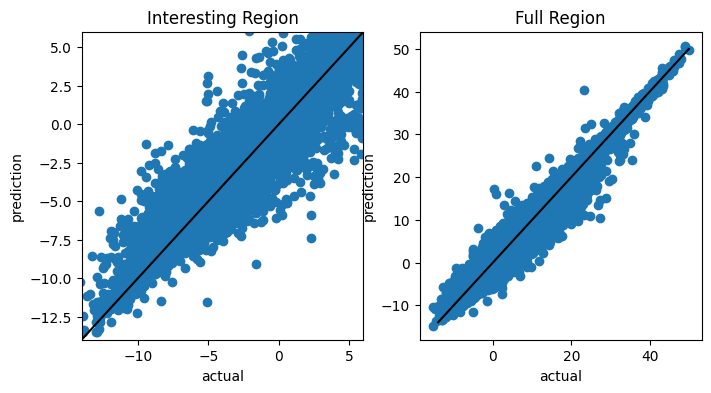

In [9]:
y_pred = predict(model, x_test_tensor).cpu()

make_graph(y_test, y_pred)

In [10]:
torch.save(model.state_dict(), f'{ARTIFACTS_PATH}/li_fnn.pt')